In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext(master='local',appName="Linear Regression")
spark = SparkSession(sparkContext=sc)

In [2]:
import numpy as np
import matplotlib.pyplot as plt 

# Gradient Descent in Python

### Generate data

In [3]:
size= 1000
x1 = np.random.rand(size)
x2 = np.random.rand(size)
beta0 = 0
beta1 = 1
beta2 = 4
x = []
for i in range(size):
    x.append(np.array([x1[i],x2[i]]))
e = np.random.rand(size)*0.2
y = beta0 + beta1*x1 + beta2*x2 + e

### Data visualisation

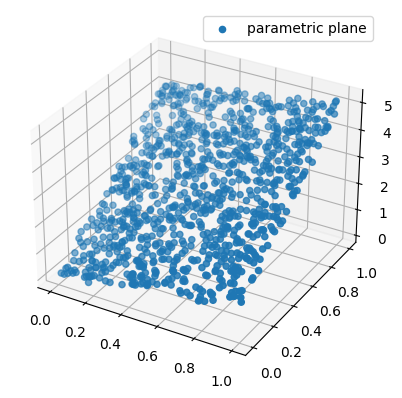

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
 
mpl.rcParams['legend.fontsize'] = 10
 
fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')

ax.scatter3D(x1, x2, y, label='parametric plane' )
ax.legend()
 
plt.show()

### Gradient Descent Algorithm

In [5]:
learningRate = 1
num_iteration = 30
m_current=np.zeros(2)
n = float(size)
# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    # Calculate the prediction with current regression coefficients. 
    cost = 0
    m_gradient = 0
    for j in range(size):
        y_prediction = np.dot(m_current,x[j])
        # We compute costs just for monitoring 
        cost += ( y[j] - y_prediction)**2
        # calculate gradients.
        m_gradient += x[j] * (y[j] - y_prediction)
    m_gradient = (-1.0/n)* m_gradient
    # update the weights - Regression Coefficients 
    m_current = m_current - learningRate * m_gradient
    print(i , "m=", m_current, " Cost=", cost/n)

0 m= [1.36756061 1.63136827]  Cost= 8.156679623291724
1 m= [1.88005797 2.3810875 ]  Cost= 1.7011558008446481
2 m= [2.03798174 2.75424796]  Cost= 0.5157222582427142
3 m= [2.05157686 2.9639547 ]  Cost= 0.27113235645904166
4 m= [2.00893384 3.10034668]  Cost= 0.19894802696427324
5 m= [1.94675203 3.20175767]  Cost= 0.16204356384785412
6 m= [1.88012798 3.28467835]  Cost= 0.13534092623093422
7 m= [1.81509373 3.35637329]  Cost= 0.11374848501398781
8 m= [1.75389279 3.4201953 ]  Cost= 0.09582299312891666
9 m= [1.697199   3.47782512]  Cost= 0.08085642480483043
10 m= [1.64504855 3.53021652]  Cost= 0.06834513051396254
11 m= [1.59723033 3.57799616]  Cost= 0.05788361823510449
12 m= [1.55344847 3.62163373]  Cost= 0.049135583663768904
13 m= [1.51338916 3.66151521]  Cost= 0.0418202935321251
14 m= [1.47674718 3.69797524]  Cost= 0.03570307931800495
15 m= [1.44323577 3.73131214]  Cost= 0.03058772113121217
16 m= [1.41258946 3.76179544]  Cost= 0.02631013800975059
17 m= [1.38456415 3.78967025]  Cost= 0.022733

# Gradient Descent in PySpark

### Generate data
- Data range infulence the learning rate (Try to change scale_x)
- Intercept calculation (adding 1 to the input data)

In [6]:
# Now we do gradient Decent on our RDD data set. 
size  = 1000 # Size of input data
scale_x = 1 # Scaling of the input data (default range is [0,1])
d = 3 # Dimensionality of the input data
theta = [-1,1,2] # The parameters of the model
theta0 = 0 # The intercept value

# Create random input varaiables
x = np.random.rand(size,d)
# Scale the input space
x = x*scale_x

# Create the data
data = []
for i in range(size):
    # Calculate the target variable
    y = np.dot(theta,x[i]) + theta0
    # Create a tuple (target_variable, array[input_varaiables]) 
    data.append((y,x[i]))

myRDD = sc.parallelize(data)
# Needed for intercept calculation
# myRDD= myRDD.map(lambda x: (x[0],np.append(x[1],1 )))
myRDD.cache()

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:274

In [7]:
myRDD.take(3)

[(1.511537122278708, array([0.25692233, 0.67551463, 0.54647241])),
 (-0.8981749922001605, array([0.95164654, 0.04257604, 0.00544775])),
 (1.1966804931675221, array([0.14324783, 0.53268485, 0.40362173]))]

### Gradient Descent Algorithm

In [8]:
learningRate = 1
num_iteration = 30

# Calculate the dimensionality of the inpit data
d_input = len(myRDD.first()[1])
beta = np.zeros(d_input)
print(f"Input dimensionalyty is {d_input} and we start wiht {beta} as parameters ")

# Let's start with main iterative part of gradient descent algorithm 
for i in range(num_iteration):
    gradientAndCost=myRDD.map(lambda x: (x[1], (x[0] - np.dot(x[1] , beta) )))\
                           .map(lambda x: (x[0]*x[1], x[1]**2 ))\
                           .reduce(lambda x, y: (x[0] +y[0], x[1]+y[1] ))
    cost= gradientAndCost[1]/size
    gradient=(-1/float(size))* gradientAndCost[0]
    beta = beta - learningRate * gradient
    print(f"{i} Cost:{cost:.5f} Beta {beta}")

Input dimensionalyty is 3 and we start wiht [0. 0. 0.] as parameters 
0 Cost:1.50555 Beta [0.40772922 0.58063195 0.66632523]
1 Cost:0.36324 Beta [0.37717446 0.70841518 0.86624989]
2 Cost:0.27547 Beta [0.27641314 0.75233482 0.97552716]
3 Cost:0.23015 Beta [0.17107456 0.77914109 1.06245648]
4 Cost:0.19306 Beta [0.07230774 0.80105927 1.13984665]
5 Cost:0.16198 Beta [-0.01850497  0.82046403  1.21045893]
6 Cost:0.13590 Beta [-0.10168916  0.83793768  1.27520563]
7 Cost:0.11403 Beta [-0.17782957  0.8537249   1.3346317 ]
8 Cost:0.09568 Beta [-0.24751297  0.86799638  1.38918465]
9 Cost:0.08028 Beta [-0.31128557  0.88089763  1.43926585]
10 Cost:0.06736 Beta [-0.36964885  0.89255887  1.48524207]
11 Cost:0.05653 Beta [-0.42306199  0.9030978   1.52744972]
12 Cost:0.04744 Beta [-0.47194519  0.91262101  1.56619762]
13 Cost:0.03981 Beta [-0.51668296  0.92122508  1.60176926]
14 Cost:0.03341 Beta [-0.55762717  0.92899748  1.63442494]
15 Cost:0.02803 Beta [-0.59509975  0.93601747  1.66440359]
16 Cost:0.0